
Raw Factor Loadings:
                       Factor_1  Factor_2  Factor_3
fixed acidity            0.498    -0.864    -0.030
volatile acidity         0.277    -0.115     0.615
citric acid              0.109    -0.298    -0.437
residual sugar           0.533     0.453    -0.503
chlorides                0.370    -0.146     0.379
free sulfur dioxide      0.010     0.350    -0.489
total sulfur dioxide     0.014     0.414    -0.697
density                  0.999     0.044    -0.000
pH                      -0.001     0.272     0.547
sulphates                0.269    -0.205     0.368
alcohol                 -0.675    -0.282     0.149
is_white                -0.407     0.357    -0.796

Varimax‐Rotated Loadings:
                       Factor_1  Factor_2  Factor_3
fixed acidity            0.157    -0.947     0.272
volatile acidity         0.122    -0.017     0.673
citric acid              0.061    -0.426    -0.325
residual sugar           0.728     0.109    -0.448
chlorides                0.232 

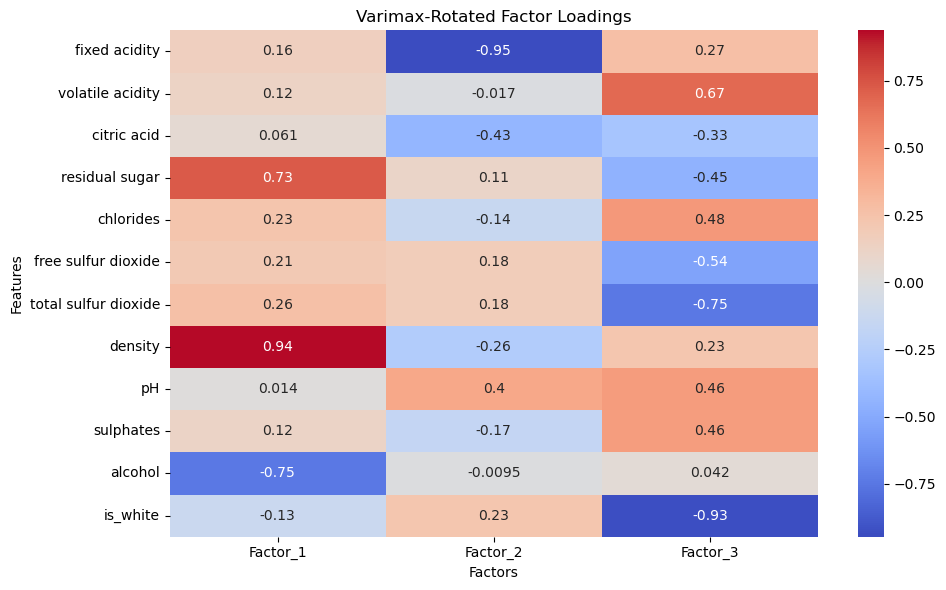


Scores preview:


,quality,is_white,Factor_1,Factor_2,Factor_3
0,5,0,1.019781,0.355347,1.962227
1,5,0,0.710754,-0.168879,1.713029
2,5,0,0.775426,-0.134318,1.721188
3,6,0,1.229712,-2.834168,0.023372
4,5,0,1.019781,0.355347,1.962227


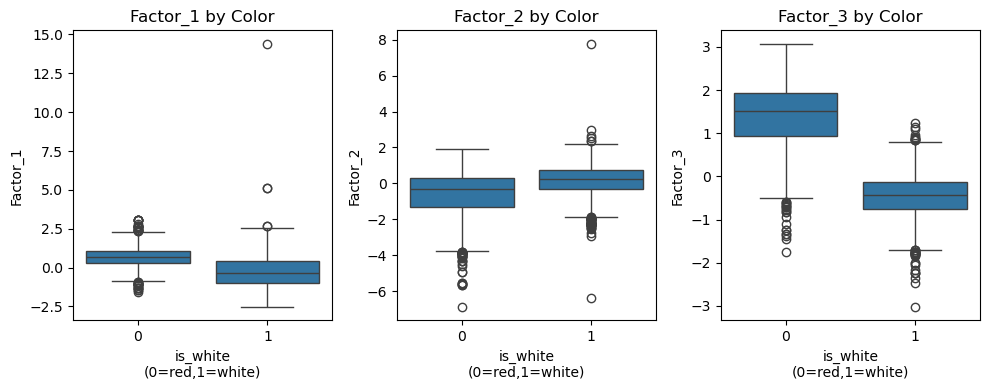


Correlation of each factor with quality:
 Factor_1   -0.302
Factor_2   -0.083
Factor_3   -0.060
Name: quality, dtype: float64


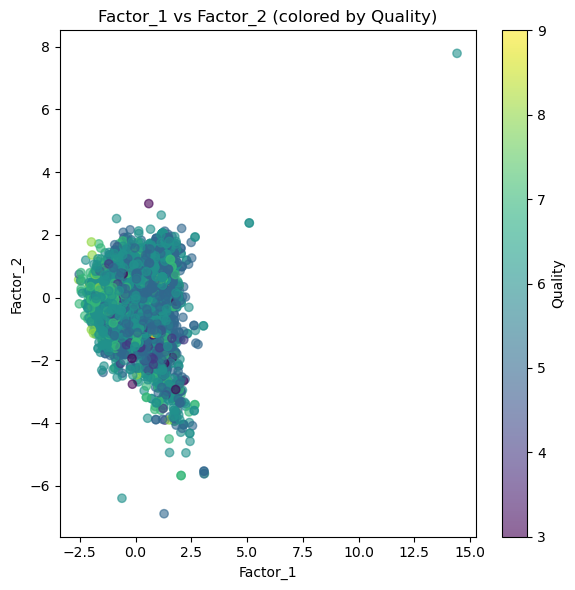

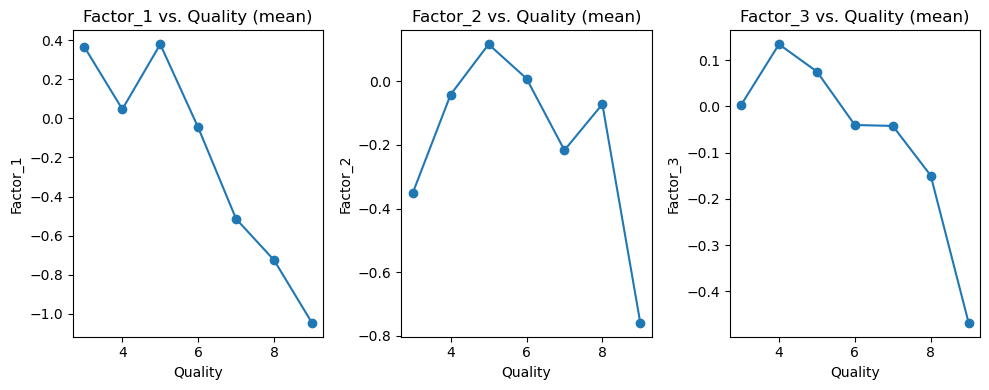

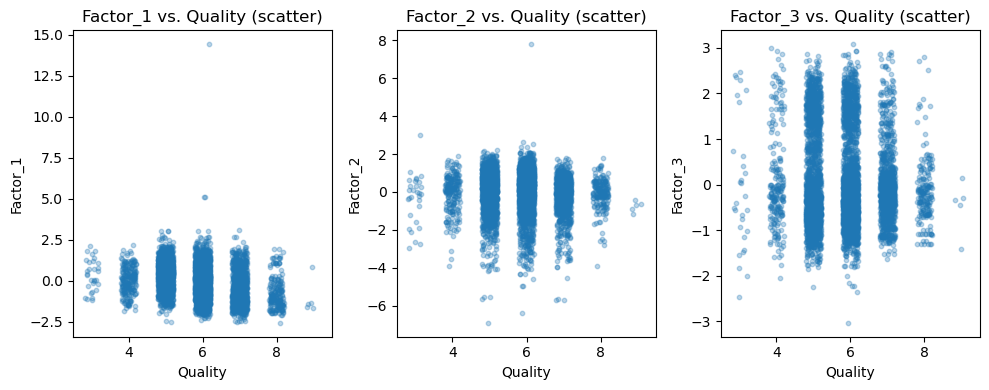

LinearRegression 5-fold CV R²: 0.014
DecisionTreeRegressor best CV R²: 0.060, params: {'max_depth': 5, 'min_samples_leaf': 5}
Feature importances: {'Factor_1': np.float64(0.727), 'Factor_2': np.float64(0.161), 'Factor_3': np.float64(0.112)}

Top clustering configs:
    k  n_init  silhouette
8  4      20    0.448579
7  4      10    0.448579
6  4       5    0.448579
2  2      20    0.432543
1  2      10    0.432543
Best → k=4.0, n_init=20.0 (sil=0.449)

Optimized Cluster profile:
              quality_count  quality_mean  ...  Factor_2_mean  Factor_3_mean
cluster_opt                               ...                              
0                     2768         6.090  ...         -0.140         -0.245
1                     1161         5.553  ...          0.010          1.756
2                     2066         5.621  ...          0.728         -0.704
3                      502         5.745  ...         -2.248          0.186

[4 rows x 5 columns]


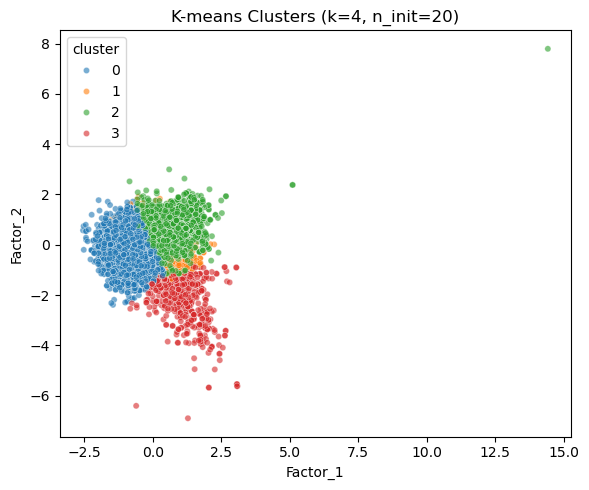

In [6]:
"""
Created on Wed Apr 23 2025
@author: lukew

Wine Quality Factor Analysis + Extended Quality Plots
"""
# ─── Imports ───────────────────────────────────────────────────────────────────
import os, csv

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing    import StandardScaler
from sklearn.decomposition     import FactorAnalysis
from sklearn.linear_model      import LinearRegression
from sklearn.tree              import DecisionTreeRegressor
from sklearn.cluster           import KMeans
from sklearn.metrics           import silhouette_score
from sklearn.model_selection   import cross_val_score, GridSearchCV

# ─── 1) File paths ─────────────────────────────────────────────────────────────
base_dir   = r"C:\Users\lukew\OneDrive\Desktop\Lukas\Python\wine-quality-analysis\data"
red_path   = os.path.join(base_dir, "winequality-red.csv")
white_path = os.path.join(base_dir, "winequality-white.csv")

# ─── 2) Load raw CSVs ──────────────────────────────────────────────────────────
# Red needs QUOTE_NONE to parse correctly:
red   = pd.read_csv(red_path, sep=';', engine='python', quoting=csv.QUOTE_NONE)
white = pd.read_csv(white_path, sep=';')

# ─── 3) Clean header quotes & whitespace ────────────────────────────────────────
def clean_headers(df):
    df.columns = (
        df.columns
          .str.replace('"','', regex=False)
          .str.strip()
    )
    return df

red   = clean_headers(red)
white = clean_headers(white)

# ─── 4) Label, combine & encode color ───────────────────────────────────────────
red['type'], white['type'] = 'red','white'
df = pd.concat([red, white], ignore_index=True)
df['is_white'] = (df['type']=='white').astype(int)
df.drop(columns='type', inplace=True)

# ─── 5) Prepare & scale feature matrix ─────────────────────────────────────────
X = df.drop(columns='quality')
scaler      = StandardScaler().fit(X)
X_scaled_np = scaler.transform(X)
X_scaled    = pd.DataFrame(X_scaled_np, columns=X.columns)

# ─── 6) Factor Analysis (3 components) ──────────────────────────────────────────
n_factors = 3
fa = FactorAnalysis(n_components=n_factors, random_state=42).fit(X_scaled)

# ─── 7) Show raw loadings ──────────────────────────────────────────────────────
loadings = pd.DataFrame(
    fa.components_.T,
    index=X.columns,
    columns=[f"Factor_{i+1}" for i in range(n_factors)]
)
print("\nRaw Factor Loadings:\n", loadings.round(3))

# ─── 8) Varimax rotation function & rotated loadings ───────────────────────────
def varimax(Phi, gamma=1.0, q=20, tol=1e-6):
    p,k = Phi.shape
    R = np.eye(k)
    d = 0
    for _ in range(q):
        L = Phi @ R
        ss = (L**2).sum(axis=0)
        M = Phi.T @ (L**3 - (gamma/p)*L*ss)
        U,s,Vt = np.linalg.svd(M)
        R = U @ Vt
        d_new = s.sum()
        if d and d_new/d < 1+tol:
            break
        d = d_new
    return Phi @ R, R

rot_vals, rot_mat = varimax(loadings.values)
rot_loadings = pd.DataFrame(rot_vals,
    index=loadings.index,
    columns=loadings.columns
)
print("\nVarimax‐Rotated Loadings:\n", rot_loadings.round(3))

# plot heatmap of rotated loadings
plt.figure(figsize=(10,6))
sns.heatmap(rot_loadings, annot=True, cmap='coolwarm', center=0)
plt.title("Varimax‐Rotated Factor Loadings")
plt.ylabel("Features")
plt.xlabel("Factors")
plt.tight_layout()
plt.show()

# ─── 9) Extract & attach factor scores ─────────────────────────────────────────
scores = fa.transform(X_scaled)
scores_df = pd.DataFrame(scores,
                         columns=loadings.columns,
                         index=df.index)
df_scores = pd.concat([df[['quality','is_white']], scores_df], axis=1)
print("\nScores preview:")
display(df_scores.head())

# ─── 10) Boxplots of factor scores by wine color ──────────────────────────────
plt.figure(figsize=(10,4))
for i in range(n_factors):
    plt.subplot(1, n_factors, i+1)
    sns.boxplot(x='is_white', y=f"Factor_{i+1}", data=df_scores)
    plt.xlabel('is_white\n(0=red,1=white)')
    plt.title(f"Factor_{i+1} by Color")
plt.tight_layout()
plt.show()

# ─── 11) Correlation with quality ──────────────────────────────────────────────
corrs = df_scores.corr().loc['quality', loadings.columns]
print("\nCorrelation of each factor with quality:\n", corrs.round(3))

# ─── 12) Scatter Factor1 vs Factor2 colored by quality ────────────────────────
plt.figure(figsize=(6,6))
sc = plt.scatter(df_scores['Factor_1'], df_scores['Factor_2'],
                 c=df_scores['quality'], cmap='viridis', alpha=0.6)
plt.colorbar(sc, label='Quality')
plt.xlabel('Factor_1')
plt.ylabel('Factor_2')
plt.title('Factor_1 vs Factor_2 (colored by Quality)')
plt.tight_layout()
plt.show()

# ─── 13) NEW: Mean factor score vs. quality ───────────────────────────────────
plt.figure(figsize=(10,4))
for i, f in enumerate(loadings.columns):
    plt.subplot(1, n_factors, i+1)
    mean_scores = df_scores.groupby('quality')[f].mean()
    plt.plot(mean_scores.index, mean_scores.values, marker='o')
    plt.xlabel('Quality')
    plt.ylabel(f)
    plt.title(f"{f} vs. Quality (mean)")
plt.tight_layout()
plt.show()

# ─── 14) NEW: Scatter + jitter of factor vs. quality ─────────────────────────
plt.figure(figsize=(10,4))
for i, f in enumerate(loadings.columns):
    plt.subplot(1, n_factors, i+1)
    x = df_scores['quality'] + np.random.uniform(-0.2,0.2, size=len(df_scores))
    plt.scatter(x, df_scores[f], alpha=0.3, s=10)
    plt.xlabel('Quality')
    plt.ylabel(f)
    plt.title(f"{f} vs. Quality (scatter)")
    plt.xlim(2.5, 9.5)
plt.tight_layout()
plt.show()

# ─── 15) Predict quality from factor scores + hyperparameter tuning ────────────
Xf = df_scores[['Factor_1','Factor_2','Factor_3']]
y  = df_scores['quality']

# 15a) Linear Regression
r2_lin = cross_val_score(LinearRegression(), Xf, y, cv=5, scoring='r2').mean()
print(f"LinearRegression 5-fold CV R²: {r2_lin:.3f}")

# 15b) Decision Tree tuning
param_grid = {
    'max_depth':      [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 5, 10, 20]
}
grid_dt = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid, cv=5, scoring='r2', n_jobs=-1
).fit(Xf, y)

best_dt, r2_dt = grid_dt.best_estimator_, grid_dt.best_score_
print(f"DecisionTreeRegressor best CV R²: {r2_dt:.3f}, params: {grid_dt.best_params_}")
print("Feature importances:", dict(zip(Xf.columns, best_dt.feature_importances_.round(3))))

# ─── 16) K-means + silhouette tuning ────────────────────────────────────────────
records = []
for k in range(2, 11):
    for n_init in (5, 10, 20):
        km = KMeans(n_clusters=k, n_init=n_init, random_state=42)
        lbl = km.fit_predict(Xf)
        records.append({'k': k, 'n_init': n_init, 'silhouette': silhouette_score(Xf, lbl)})

tune_df = pd.DataFrame(records).sort_values('silhouette', ascending=False)
best_row = tune_df.iloc[0]
print("\nTop clustering configs:\n", tune_df.head(5))
print(f"Best → k={best_row.k}, n_init={best_row.n_init} (sil={best_row.silhouette:.3f})")

km_opt = KMeans(n_clusters=int(best_row.k), n_init=int(best_row.n_init), random_state=42)
df_scores['cluster_opt'] = km_opt.fit_predict(Xf)

profile = df_scores.groupby('cluster_opt').agg({
    'quality': ['count','mean'],
    'Factor_1':'mean','Factor_2':'mean','Factor_3':'mean'
})
profile.columns = ["_".join(c) for c in profile.columns]
print("\nOptimized Cluster profile:\n", profile.round(3))

plt.figure(figsize=(6,5))
sns.scatterplot(
    x='Factor_1', y='Factor_2',
    hue='cluster_opt', palette='tab10',
    data=df_scores, alpha=0.6, s=20
)
plt.title(f"K-means Clusters (k={int(best_row.k)}, n_init={int(best_row.n_init)})")
plt.legend(title="cluster")
plt.tight_layout()
plt.show()
